# Generative Adversarial Network (GAN)

![](https://nbviewer.jupyter.org/github/hse-aml/intro-to-dl/blob/master/week4/images/gan.png)

Пришло время поговорить о более интересных архитектурах, а именно о GANах или состязательных нейронных сетках. [Впервые GANы были предложены в 2014 году.](https://arxiv.org/abs/1406.2661) Сейчас они очень активно исследуются. GANы состоят из двух нейронных сетей: 

* Первая - генератор порождает из некоторого заданного распределения случайные числа и собирает из них объекты, которые идут на вход второй сети. 
* Вторая - дискриминатор получает на вход объекты из реальной выборки и объекты, созданные генератором. Она пытается определить какой объект был порождён генератором, а какой является реальным.

Таким образом генератор пытается создавать объекты, которые дискриминатор не сможет отличить от реальных. 

In [1]:
import tensorflow as tf
print(tf.__version__)

2.0.0


In [2]:
import numpy as np
import time 

import matplotlib.pyplot as plt
%matplotlib inline

# 1. Данные

Для начала давайте попробуем погонять модели на рукописных цифрах из MNIST как бы скучно это не было. 

In [9]:
(X, _ ), (_, _) = tf.keras.datasets.mnist.load_data()

In [10]:
X = X/127.5 - 1 # отнормировали данные на отрезок [-1, 1]

In [11]:
X.min(), X.max()  # проверили нормировку

(-1.0, 1.0)

In [12]:
X = X[:,:,:,np.newaxis]
X.shape

(60000, 28, 28, 1)

Давайте вытащим несколько рандомных картинок и нарисуем их.

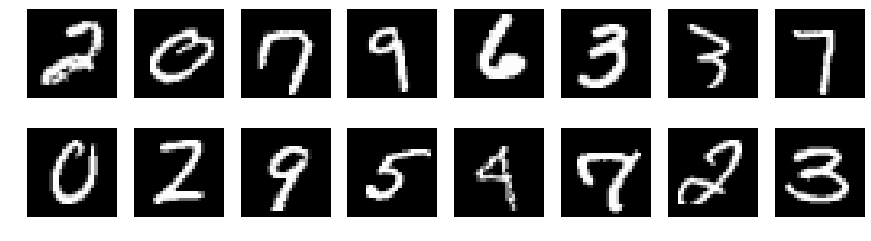

In [13]:
cols = 8
rows = 2
fig = plt.figure(figsize=(2 * cols - 1, 2.5 * rows - 1))
for i in range(cols):
    for j in range(rows):
        random_index = np.random.randint(0, X.shape[0])
        ax = fig.add_subplot(rows, cols, i * rows + j + 1)
        ax.grid(False)
        ax.axis('off')
        ax.imshow(np.squeeze(X,-1)[random_index, :], cmap='gray')
plt.show()

Соберём для наших данных удобный генератор. 

# 2. Дискриминатор 

* Дискриминатор - это обычная свёрточная сетка 
* Цель этой сетки - отличать сгенерированные изображения от реальных

In [14]:
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras import layers as L

In [15]:
IMG_SHAPE = X.shape[1:]

In [17]:
discriminator = Sequential()

discriminator.add(L.Conv2D(64, kernel_size=(5,5), 
                           strides=(2, 2), 
                           input_shape=IMG_SHAPE))
discriminator.add(L.BatchNormalization())
discriminator.add(L.LeakyReLU())

discriminator.add(L.Conv2D(128, kernel_size=(5,5), 
                           strides=(2, 2)))
discriminator.add(L.BatchNormalization())
discriminator.add(L.LeakyReLU())

discriminator.add(L.Flatten())

# на выход из дискриминатора мы забираем логарифм, а не вероятность 
discriminator.add(L.Dense(2, activation=tf.nn.log_softmax))

# 3. Генератор

* Генерирует из шума изображения 

Будем генерировать новых Симпсонов из шума размера 256.

In [18]:
CODE_SIZE = 100

In [22]:
generator = Sequential()

generator.add(L.InputLayer([CODE_SIZE],name='noise'))

generator.add(L.Dense(256*7*7, activation='elu'))
generator.add(L.Reshape((7,7,256)))

generator.add(L.Conv2DTranspose(128, kernel_size=(3,3)))
generator.add(L.LeakyReLU())

generator.add(L.Conv2DTranspose(64, kernel_size=(3,3)))
generator.add(L.LeakyReLU())

generator.add(L.UpSampling2D(size=(2,2)))
generator.add(L.Conv2DTranspose(32,kernel_size=3,activation='elu'))
generator.add(L.Conv2DTranspose(32,kernel_size=3,activation='elu'))
generator.add(L.Conv2DTranspose(32,kernel_size=3,activation='elu'))

generator.add(L.Conv2D(1, kernel_size=3, padding='same'))

print('Выход генератора: ', generator.output_shape[1:])

Выход генератора:  (28, 28, 1)


Посмотрим на пример, который нам генерирует на выход наша свежая нейронка! 

In [26]:
noise = tf.random.normal([1, CODE_SIZE])
noise.shape

TensorShape([1, 100])

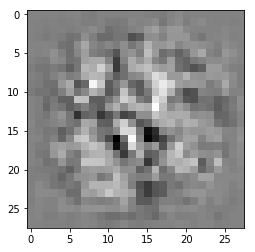

In [27]:
generated_image =  generator(noise)

plt.imshow(generated_image[0, :, :, 0], cmap='gray');

Хммм... А что про это всё думает дескриминатор?

In [30]:
decision = discriminator(generated_image)

# на выход из дискриминатора мы забираем логарифм!
np.exp(decision)

array([[0.49975646, 0.50024354]], dtype=float32)

# 4. Функция потерь 

Потери для дескриминатора это обычныя кросс-энтропия.

In [33]:
def discriminator_loss(logp_real, logp_gen):
    # Потери для дискриминатора 
    # Ваш код
    d_loss = -1*tf.reduce_mean(logp_gen[:,0])
    d_loss -= tf.reduce_mean(logp_real[:,1])
    
    d_loss += tf.reduce_mean(discriminator.weights[-2]**2)
    return d_loss

In [51]:
real_log = discriminator(X[:1])
gen_log = discriminator(generated_image)

discriminator_loss(real_log, gen_log)

<tf.Tensor: id=2682, shape=(), dtype=float32, numpy=1.4049389>

Для генератора мы хотим максимизировать ошибку дискриминатора на фэйковых примерах. 

In [52]:
def generator_loss(logp_gen):
    # Потери для генератора
    # Ваш код 
    g_loss = tf.reduce_mean(logp_gen[:,0])
    return g_loss

In [53]:
generator_loss(gen_log)

<tf.Tensor: id=2688, shape=(), dtype=float32, numpy=-0.6936344>

# 5. Градиентный спуск

Учить пару из сеток будем так: 

* Делаем $k$ шагов обучения дискриминатора. Целевая переменная - реальный объект перед нами или порождённый. Веса изменяем стандартно, пытаясь уменьшить кросс-энтропию.
* Делаем $m$ шагов обучения генератора. Веса внутри сетки меняем так, чтобы увеличить логарифм вероятности дискриминатора присвоить сгенерированному объекту лэйбл реального. 
* Обучаем итеративно до тех пор, пока дискриминатор больше не сможет найти разницу (либо пока у нас не закончится терпение).
* При обучении может возникнуть огромное количество пробем от взрыва весов до более тонких вещей. Имеет смысл посмотреть на разные трюки, используемые при обучении:  https://github.com/soumith/ganhacks

Собираем структуру для обучения.

In [54]:
generator_optimizer = tf.keras.optimizers.Adam(1e-4)
discriminator_optimizer = tf.keras.optimizers.Adam(1e-4)
#discriminator_optimizer = tf.keras.optimizers.SGD(1e-3)

Чекпойнты для процесса обучения.

In [55]:
import os 
checkpoint_dir = './training_checkpoints'

checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")

checkpoint = tf.train.Checkpoint(generator_optimizer=generator_optimizer,
                                 discriminator_optimizer=discriminator_optimizer,
                                 generator=generator,
                                 discriminator=discriminator)

Задаём один шаг процедуры обучения генератора.

In [56]:
@tf.function
def train_generator_step(images, noise):

    # ищем градиенты 
    with tf.GradientTape() as gen_tape:
        
        # сгенерировали новое изображение из шума
        generated_images = generator(noise)
        
        # посчитали прогнозы дискриминатора
        real_output = discriminator(images)
        fake_output = discriminator(generated_images)
        
        # нашли ошибку
        gen_loss = generator_loss(fake_output)
        
    # нашли градиенты
    grad = gen_tape.gradient(gen_loss, generator.trainable_variables)
        
    # сделали шаг градиентного спуска 
    generator_optimizer.apply_gradients(zip(grad, generator.trainable_variables))
    pass

Теперь шаг обучения дискриминатора. 

In [57]:
@tf.function
def train_discriminator_step(images, noise):
    
   # ищем градиенты 
    with tf.GradientTape() as gen_tape:
        
        # сгенерировали новое изображение из шума
        generated_images = generator(noise)
        
        # посчитали прогнозы дискриминатора
        real_output = discriminator(images)
        fake_output = discriminator(generated_images)
        
        # нашли ошибку
        dis_loss = discriminator_loss(real_output,fake_output)
        
    # нашли градиенты
    grad = gen_tape.gradient(dis_loss, discriminator.trainable_variables)
        
    # сделали шаг градиентного спуска 
    generator_optimizer.apply_gradients(zip(grad, discriminator.trainable_variables))
    pass

Мы почти готовы учить нашу сетку. Напишем две простенькие функции для генерации фэйковых и настоящих батчей. 

In [58]:
# функция, которая генерирует батч с шумом
def sample_noise_batch(bsize):
    return tf.random.normal([bsize, CODE_SIZE], dtype=tf.float32)


# функция, которая генерирует батч из реальных данных (для баловства)
def sample_data_batch(bsize):
    idxs = np.random.choice(np.arange(X.shape[0]), size=bsize)
    return X[idxs]

Проверяем отрабатывают ли наши шаги.

In [59]:
data_test = sample_data_batch(256)
fake_test = sample_noise_batch(256)

gen_log = discriminator(generator(fake_test))
real_log = discriminator(data_test)

print('Ошибка дескриминатора:', discriminator_loss(real_log, gen_log).numpy())
print('Ошибка генератора:', generator_loss(gen_log).numpy())

Ошибка дескриминатора: 1.3821939
Ошибка генератора: -0.6970318


In [60]:
# сделали шаг работы генератора
train_generator_step(data_test, fake_test)

gen_log = discriminator(generator(fake_test))
real_log = discriminator(data_test)

print('Ошибка дескриминатора:', discriminator_loss(real_log, gen_log).numpy())
print('Ошибка генератора:', generator_loss(gen_log).numpy())

Ошибка дескриминатора: 1.3877242
Ошибка генератора: -0.7025621


In [64]:
# сделали шаг работы дискриминатора
train_discriminator_step(data_test, fake_test)

gen_log = discriminator(generator(fake_test))
real_log = discriminator(data_test)

print('Ошибка дескриминатора:', discriminator_loss(real_log, gen_log).numpy())
print('Ошибка генератора:', generator_loss(gen_log).numpy())

Ошибка дескриминатора: 1.2008832
Ошибка генератора: -0.7058904


Как думаете, выглядит адекватно? Мы нигде не ошиблись? 

Напишем пару вспомогательных функций для отрисовки картинок. 

In [65]:
# рисуем изображения
def sample_images(rows, cols, num=0):
    images = generator.predict(sample_noise_batch(bsize=rows*cols))
    
    fig = plt.figure(figsize=(2 * cols - 1, 2.5 * rows - 1))
    for i in range(cols):
        for j in range(rows):
            ax = fig.add_subplot(rows, cols, i * rows + j + 1)
            ax.grid('off')
            ax.axis('off')
            ax.imshow(np.squeeze(images[i * rows + j],-1),cmap='gray')
    
    # сохраняем картинку для гифки
    if num >0:
        plt.savefig('images_gan/image_at_epoch_{:04d}.png'.format(num))
    plt.show()


# рисуем распределения
def sample_probas(X):
    plt.title('Generated vs real data')
    
    plt.hist(np.exp(discriminator.predict(X))[:,1],
             label='D(x)', alpha=0.5,range=[0,1])
    
    plt.hist(np.exp(discriminator.predict(generator.predict(sample_noise_batch(X.shape[0]))))[:,1],
             label='D(G(z))',alpha=0.5,range=[0,1])
    
    plt.legend(loc='best')
    plt.show()

/usr/local/lib/python3.7/site-packages/matplotlib/cbook/__init__.py:424: MatplotlibDeprecationWarning: 
Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warn_deprecated("2.2", "Passing one of 'on', 'true', 'off', 'false' as a "


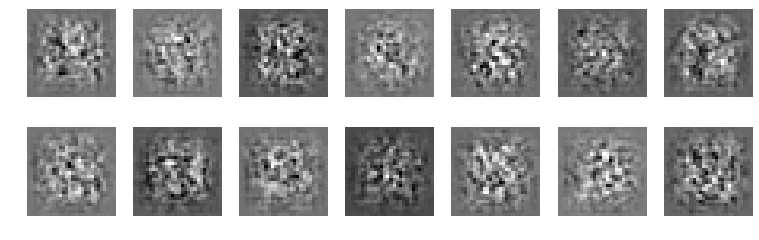

In [66]:
sample_images(2,7)

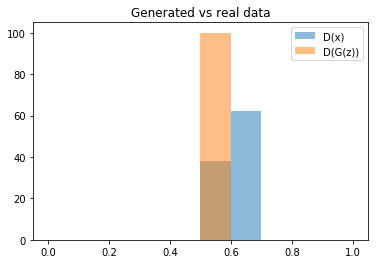

In [67]:
sample_probas(X[:100]) 

Немного побалуемся с шагами. 

In [74]:
data_test = sample_data_batch(256)
fake_test = sample_noise_batch(256)

# Генератор
train_generator_step(data_test, fake_test)

gen_log = discriminator(generator(fake_test))
real_log = discriminator(data_test)

print('Ошибка дескриминатора:', discriminator_loss(real_log, gen_log).numpy())
print('Ошибка генератора:', generator_loss(gen_log).numpy())

Ошибка дескриминатора: 1.123008
Ошибка генератора: -0.7180641


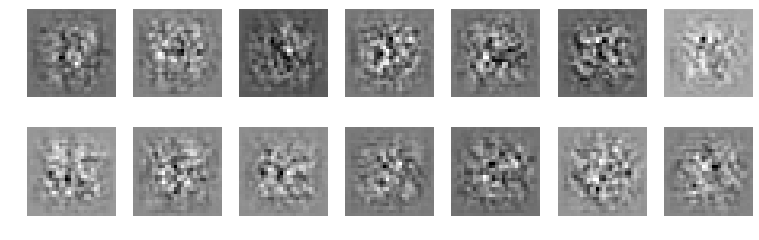

In [75]:
sample_images(2,7)

In [72]:
data_test = sample_data_batch(256)
fake_test = sample_noise_batch(256)

# Дискриминатор
train_discriminator_step(data_test, fake_test)

gen_log = discriminator(generator(fake_test))
real_log = discriminator(data_test)

print('Ошибка дескриминатора:', discriminator_loss(real_log, gen_log).numpy())
print('Ошибка генератора:', generator_loss(gen_log).numpy())

Ошибка дескриминатора: 1.1154168
Ошибка генератора: -0.70963913


# 6. Обучение

Ну и наконец последний шаг. Тренировка сеток.  При обучении нужно соблюдать между сетками баланс. Важно сделать так, чтобы ни одна из них не стала сразу же побеждать. Иначе обучение остановится. 

* Чтобы избежать моментального выигрыша дискриминатора, мы добавили в его функцию потерь $l_2$ регуляризацию. 
* Кроме регуляризации можно пытаться учить модели сбалансированно, делая внутри цикла шаги чуть более умным способом. 


Time for epoch 1 is 0.051986176520586014 min
error D: 0.9616665840148926, error G: -0.733620822429657


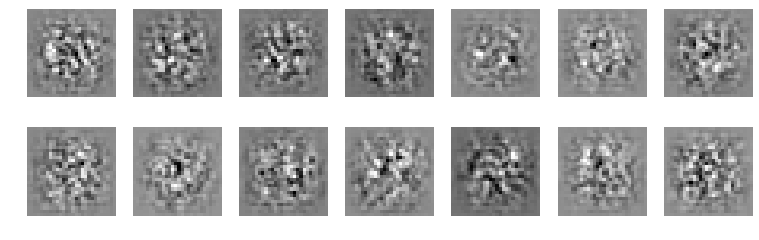

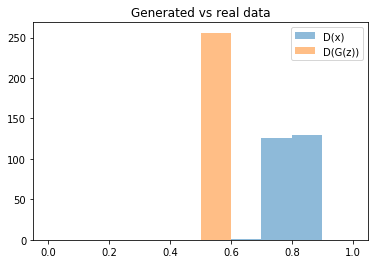

Time for epoch 2 is 0.14309339597821236 min
error D: 0.8713639974594116, error G: -0.755751371383667
Time for epoch 3 is 0.20311498269438744 min
error D: 0.8475480079650879, error G: -0.7894017696380615
Time for epoch 4 is 0.26614726334810257 min
error D: 0.8585466146469116, error G: -0.8251792192459106
Time for epoch 5 is 0.32602281123399734 min
error D: 0.8670146465301514, error G: -0.8419585824012756
Time for epoch 6 is 0.39016906172037125 min
error D: 0.8176099061965942, error G: -0.7883791923522949
Time for epoch 7 is 0.4507625438272953 min
error D: 0.6861464381217957, error G: -0.6465140581130981
Time for epoch 8 is 0.5111337825655937 min
error D: 0.5303881764411926, error G: -0.4668436646461487
Time for epoch 9 is 0.570877194404602 min
error D: 0.40221256017684937, error G: -0.3183642625808716
Time for epoch 10 is 0.6300640776753426 min
error D: 0.3113093972206116, error G: -0.22250205278396606
Time for epoch 11 is 0.6936125792562962 min
error D: 0.25709810853004456, error G: -0

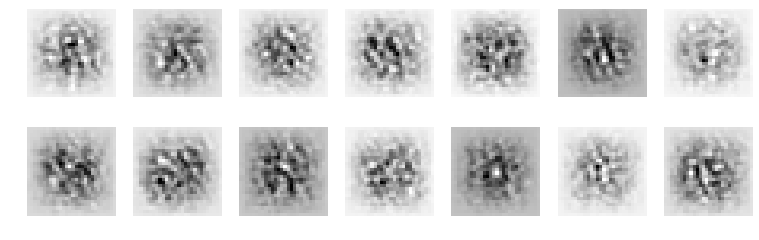

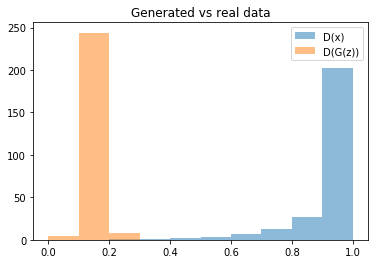

Time for epoch 12 is 0.7872799634933472 min
error D: 0.21851897239685059, error G: -0.157528817653656
Time for epoch 13 is 0.8516135439276695 min
error D: 0.21640676259994507, error G: -0.17421823740005493
Time for epoch 14 is 0.9102287143468857 min
error D: 0.2363804131746292, error G: -0.21070867776870728
Time for epoch 15 is 0.9745626114308834 min
error D: 0.29926300048828125, error G: -0.27628085017204285
Time for epoch 16 is 1.0459340959787369 min
error D: 0.4229777753353119, error G: -0.3924017548561096
Time for epoch 17 is 1.1153364665806293 min
error D: 0.5869230031967163, error G: -0.5435584783554077
Time for epoch 18 is 1.174863513559103 min
error D: 0.822172224521637, error G: -0.7911713123321533
Time for epoch 19 is 1.2395642846822739 min
error D: 0.9262543320655823, error G: -0.9073656797409058
Time for epoch 20 is 1.3112408481538296 min
error D: 0.912373423576355, error G: -0.9089843034744263
Time for epoch 21 is 1.3712762147188187 min
error D: 0.7126774191856384, error G

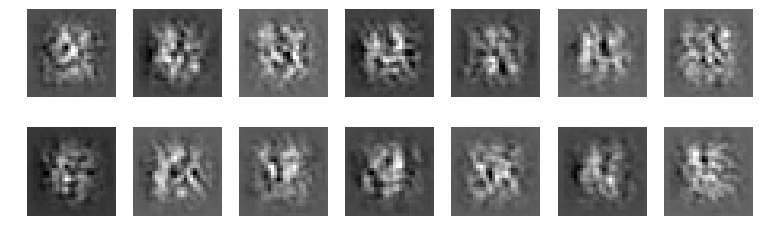

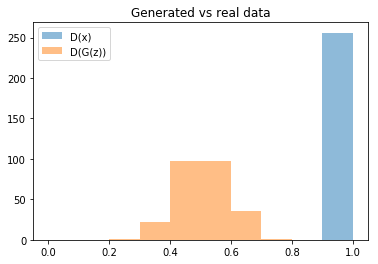

Time for epoch 22 is 1.4582940340042114 min
error D: 0.45781171321868896, error G: -0.45749935507774353
Time for epoch 23 is 1.5157785788178444 min
error D: 0.19997255504131317, error G: -0.19990602135658264
Time for epoch 24 is 1.5796009823679924 min
error D: 0.06071032956242561, error G: -0.060678645968437195
Time for epoch 25 is 1.6489165462553501 min
error D: 0.016575831919908524, error G: -0.01656060665845871
Time for epoch 26 is 1.7203895598649979 min
error D: 0.004723323509097099, error G: -0.004714701324701309
Time for epoch 27 is 1.7769754119217396 min
error D: 0.0018199416808784008, error G: -0.0017844729591161013
Time for epoch 28 is 1.8411111161112785 min
error D: 0.0008299887413159013, error G: -0.0008240522583946586
Time for epoch 29 is 1.906941581517458 min
error D: 0.0006246736156754196, error G: -0.00041768583469092846
Time for epoch 30 is 1.9772037975490093 min
error D: 0.00025661822292022407, error G: -0.0002348848502151668
Time for epoch 31 is 2.040006462484598 min


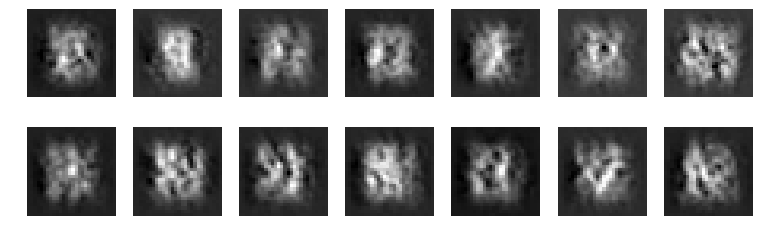

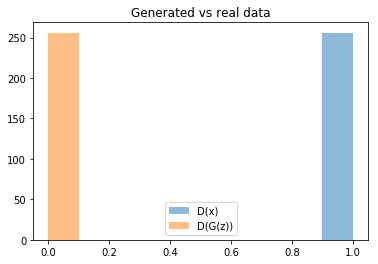

Time for epoch 32 is 2.1227892972528934 min
error D: 0.00011216900747967884, error G: -9.610942652216181e-05
Time for epoch 33 is 2.1843884140253067 min
error D: 8.298738248413429e-05, error G: -7.371012179646641e-05
Time for epoch 34 is 2.248769663274288 min
error D: 7.194977661129087e-05, error G: -6.247063720365986e-05
Time for epoch 35 is 2.3058569096028805 min
error D: 0.00016663430142216384, error G: -4.841881673200987e-05
Time for epoch 36 is 2.3616648614406586 min
error D: 5.795738979941234e-05, error G: -3.802491846727207e-05
Time for epoch 37 is 2.417897179722786 min
error D: 4.068722773808986e-05, error G: -3.1663985282648355e-05
Time for epoch 38 is 2.490555379539728 min
error D: 3.8461981603177264e-05, error G: -2.9128830647096038e-05
Time for epoch 39 is 2.566031266003847 min
error D: 3.276828283560462e-05, error G: -2.037787089648191e-05
Time for epoch 40 is 2.6308955624699593 min
error D: 4.2616247810656205e-05, error G: -2.297419632668607e-05
Time for epoch 41 is 2.706

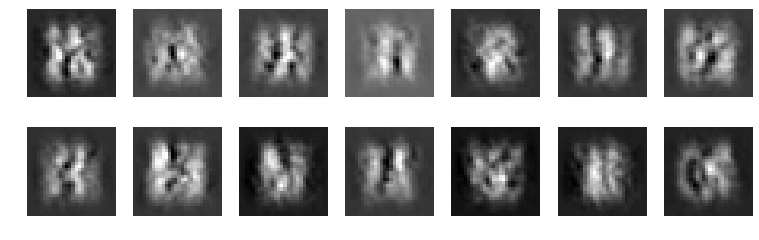

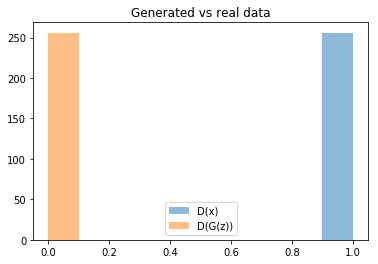

Time for epoch 42 is 2.815697345882654 min
error D: 5.33213751623407e-05, error G: -1.7304530047113076e-05
Time for epoch 43 is 2.8842017129063606 min
error D: 2.1837824533577077e-05, error G: -1.3608718290925026e-05
Time for epoch 44 is 2.9486361630260944 min
error D: 3.817183096543886e-05, error G: -1.451994467061013e-05
Time for epoch 45 is 3.020170632749796 min
error D: 0.00014240697782952338, error G: -1.2489761502365582e-05
Time for epoch 46 is 3.080787532031536 min
error D: 4.780951712746173e-05, error G: -1.2711867384496145e-05
Time for epoch 47 is 3.148048609495163 min
error D: 1.8915976397693157e-05, error G: -1.1551915122254286e-05
Time for epoch 48 is 3.219302847981453 min
error D: 1.3961824151920155e-05, error G: -9.558031706546899e-06
Time for epoch 49 is 3.2973056621849537 min
error D: 1.687807889538817e-05, error G: -9.20369438972557e-06
Time for epoch 50 is 3.3772025778889656 min
error D: 2.4316817871294916e-05, error G: -9.611564564693253e-06
Time for epoch 51 is 3.45

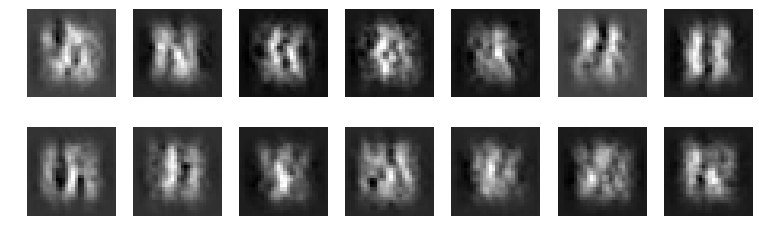

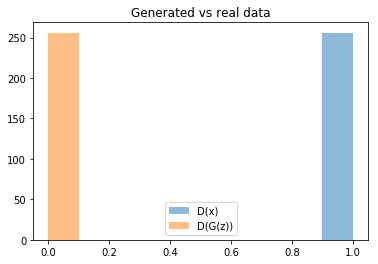

Time for epoch 52 is 3.5412425622344017 min
error D: 1.722644446999766e-05, error G: -8.441384125035256e-06
Time for epoch 53 is 3.5978946648538113 min
error D: 1.2412247087922879e-05, error G: -7.319195447053062e-06
Time for epoch 54 is 3.6549248285591602 min
error D: 1.5315861674025655e-05, error G: -7.0384076025220565e-06
Time for epoch 55 is 3.711620032787323 min
error D: 1.1755816558434162e-05, error G: -7.315004040719941e-06
Time for epoch 56 is 3.768117681145668 min
error D: 2.3418639102601446e-05, error G: -7.014646598690888e-06
Time for epoch 57 is 3.8245589770376682 min
error D: 1.4387844203156419e-05, error G: -7.480753083655145e-06
Time for epoch 58 is 3.8807214461266994 min
error D: 2.3398220946546644e-05, error G: -7.361563802987803e-06
Time for epoch 59 is 3.937194261699915 min
error D: 1.8019010894931853e-05, error G: -6.645855137321632e-06
Time for epoch 60 is 3.9955768659710884 min
error D: 2.0532144844764844e-05, error G: -6.364110959111713e-06
Time for epoch 61 is 4

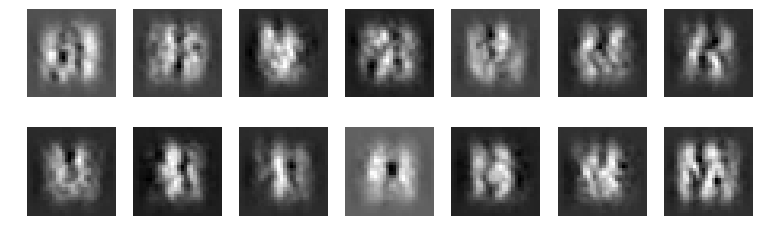

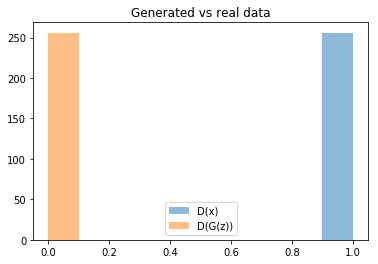

Time for epoch 62 is 4.17396629601717 min
error D: 1.7234897313755937e-05, error G: -5.640042672894197e-06
Time for epoch 63 is 4.235884394496679 min
error D: 6.433264206862077e-05, error G: -5.493363460118417e-06
Time for epoch 64 is 4.299514297395945 min
error D: 0.002700366312637925, error G: -6.947120709810406e-06
Time for epoch 65 is 4.361284013837576 min
error D: 2.598729042802006e-05, error G: -6.535952252306743e-06
Time for epoch 66 is 4.417648695409298 min
error D: 1.9311675714561716e-05, error G: -7.032336725387722e-06
Time for epoch 67 is 4.4735879972577095 min
error D: 1.58626808115514e-05, error G: -7.029081643850077e-06
Time for epoch 68 is 4.542974028736353 min
error D: 1.4821807781117968e-05, error G: -7.60275997890858e-06
Time for epoch 69 is 4.614544812589884 min
error D: 2.492159910616465e-05, error G: -7.161797384469537e-06
Time for epoch 70 is 4.684635147452354 min
error D: 1.896029061754234e-05, error G: -6.1755499700666405e-06
Time for epoch 71 is 4.7552131749689

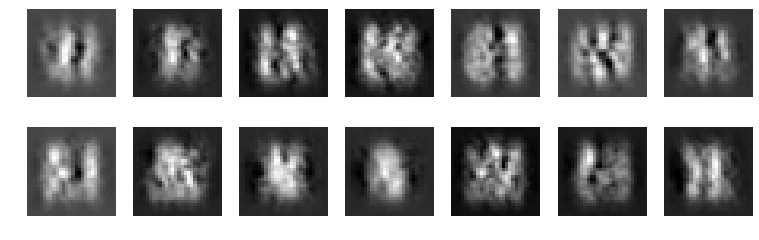

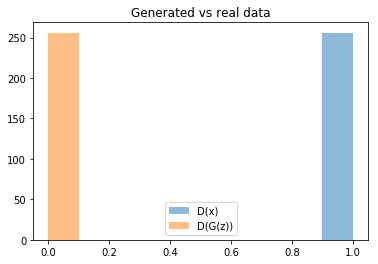

Time for epoch 72 is 4.838119648396969 min
error D: 1.60348918143427e-05, error G: -6.402326107490808e-06
Time for epoch 73 is 4.894003547728062 min
error D: 3.294911948614754e-05, error G: -7.775990525260568e-06
Time for epoch 74 is 4.9497740641236305 min
error D: 7.930650463094935e-05, error G: -6.971340553718619e-06
Time for epoch 75 is 5.00566953420639 min
error D: 1.5914483810774982e-05, error G: -6.74781585985329e-06
Time for epoch 76 is 5.062102846801281 min
error D: 1.4191493391990662e-05, error G: -7.142204594856594e-06
Time for epoch 77 is 5.119141314178705 min
error D: 9.923054312821478e-05, error G: -7.857003765820991e-06
Time for epoch 78 is 5.175996746867895 min
error D: 4.90976708533708e-05, error G: -6.179716820042813e-06
Time for epoch 79 is 5.231950897723436 min
error D: 1.1739782166841906e-05, error G: -6.719889825035352e-06
Time for epoch 80 is 5.288002483546734 min
error D: 2.330477218492888e-05, error G: -6.840480637038127e-06
Time for epoch 81 is 5.34376258030533

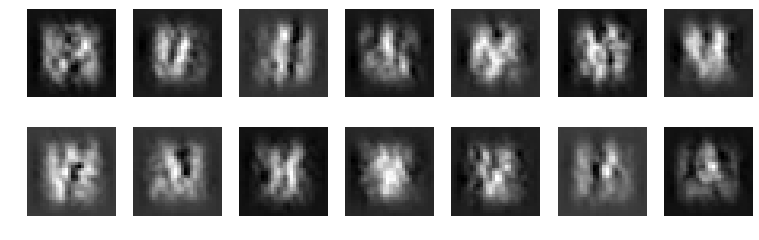

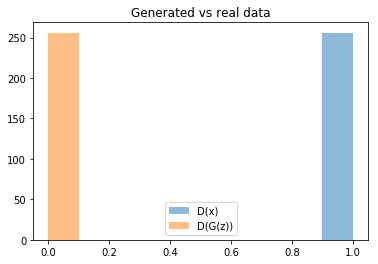

Time for epoch 82 is 5.426711264997721 min
error D: 1.5276842532330193e-05, error G: -7.676325367356185e-06
Time for epoch 83 is 5.4829168282449245 min
error D: 1.7090762412408367e-05, error G: -7.189260941231623e-06
Time for epoch 84 is 5.539087116718292 min
error D: 0.00034546959795989096, error G: -7.67396795708919e-06
Time for epoch 85 is 5.597035311162472 min
error D: 1.4071420991967898e-05, error G: -7.568785349576501e-06
Time for epoch 86 is 5.652752794325352 min
error D: 3.2904867111938074e-05, error G: -6.947513611521572e-06
Time for epoch 87 is 5.708382915705442 min
error D: 1.4639750588685274e-05, error G: -7.641419870196842e-06
Time for epoch 88 is 5.763959512114525 min
error D: 2.4312925233971328e-05, error G: -6.5606536736595444e-06
Time for epoch 89 is 5.819631099700928 min
error D: 2.561573637649417e-05, error G: -5.791845069325063e-06
Time for epoch 90 is 5.875500250607729 min
error D: 1.2689786672126502e-05, error G: -6.936886620678706e-06
Time for epoch 91 is 5.93117

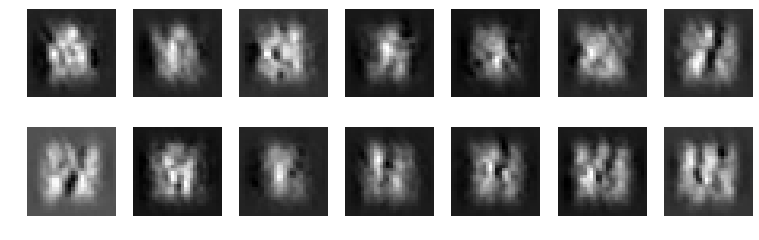

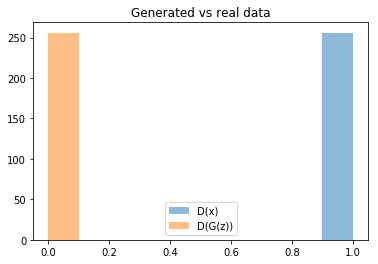

Time for epoch 92 is 6.015050649642944 min
error D: 1.9306899048388004e-05, error G: -6.637905698880786e-06
Time for epoch 93 is 6.071170762181282 min
error D: 2.2189902665559202e-05, error G: -7.986448508745525e-06
Time for epoch 94 is 6.127580348402262 min
error D: 0.00019773318490479141, error G: -7.512436241086107e-06
Time for epoch 95 is 6.183326847851276 min
error D: 2.3384582163998857e-05, error G: -6.831637620052788e-06
Time for epoch 96 is 6.240042578428984 min
error D: 1.4810770153417252e-05, error G: -8.497258932038676e-06
Time for epoch 97 is 6.295778047293425 min
error D: 2.4674905944266357e-05, error G: -6.5639055719657335e-06
Time for epoch 98 is 6.3517104759812355 min
error D: 1.7867603673948906e-05, error G: -6.663552994723432e-06
Time for epoch 99 is 6.408309265971184 min
error D: 1.735720616125036e-05, error G: -6.706383828714024e-06
Time for epoch 100 is 6.463840462267399 min
error D: 1.0923746231128462e-05, error G: -7.695408385188784e-06
Time for epoch 101 is 6.51

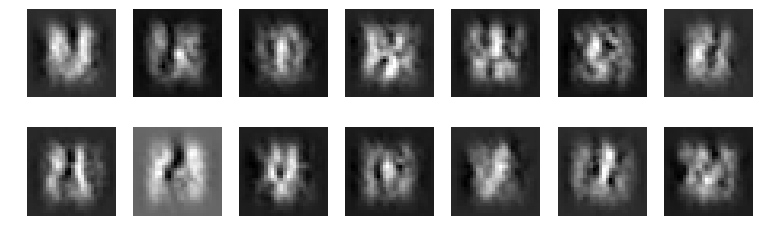

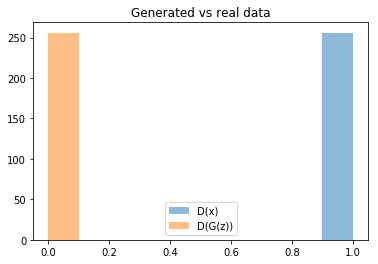

Time for epoch 102 is 6.603884596377611 min
error D: 1.9374087059986778e-05, error G: -7.622325028933119e-06
Time for epoch 103 is 6.659771915525198 min
error D: 9.597549251338933e-06, error G: -6.997860509727616e-06
Time for epoch 104 is 6.715075444430113 min
error D: 1.161051113740541e-05, error G: -7.897446266724728e-06
Time for epoch 105 is 6.771831814199686 min
error D: 4.2067265894729644e-05, error G: -6.369262337102555e-06
Time for epoch 106 is 6.8408995643258095 min
error D: 1.1393171007512137e-05, error G: -8.359915227629244e-06
Time for epoch 107 is 6.919333264231682 min
error D: 1.1300787264190149e-05, error G: -6.573685823241249e-06
Time for epoch 108 is 6.977866180241108 min
error D: 1.3690802916244138e-05, error G: -7.544541404058691e-06
Time for epoch 109 is 7.033469378948212 min
error D: 1.5191728380159475e-05, error G: -7.5221983024675865e-06
Time for epoch 110 is 7.105298265814781 min
error D: 1.1340869605191983e-05, error G: -7.3960263762273826e-06
Time for epoch 111

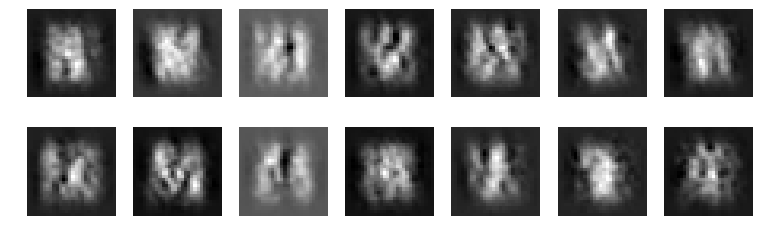

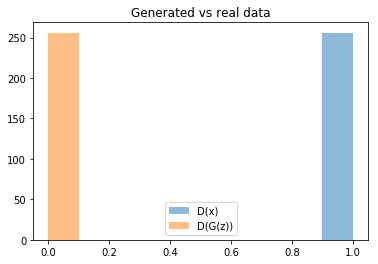

Time for epoch 112 is 7.250919863581657 min
error D: 9.18264686333714e-06, error G: -5.835163847223157e-06
Time for epoch 113 is 7.306506011635065 min
error D: 1.5216864994727075e-05, error G: -7.1333938649331685e-06
Time for epoch 114 is 7.36333530023694 min
error D: 1.8683727830648422e-05, error G: -1.028718088491587e-05
Time for epoch 115 is 7.42061698064208 min
error D: 3.355479930178262e-05, error G: -8.135462849168107e-06
Time for epoch 116 is 7.476504776626825 min
error D: 9.235343895852566e-06, error G: -7.279602414200781e-06
Time for epoch 117 is 7.5329771265387535 min
error D: 9.948716979124583e-06, error G: -7.78019330027746e-06
Time for epoch 118 is 7.589694730937481 min
error D: 1.227833217853913e-05, error G: -6.799051334382966e-06
Time for epoch 119 is 7.646184798330069 min
error D: 6.310641037998721e-05, error G: -7.902524885139428e-06
Time for epoch 120 is 7.702116396278143 min
error D: 1.456207701266976e-05, error G: -7.664690201636404e-06
Time for epoch 121 is 7.7581

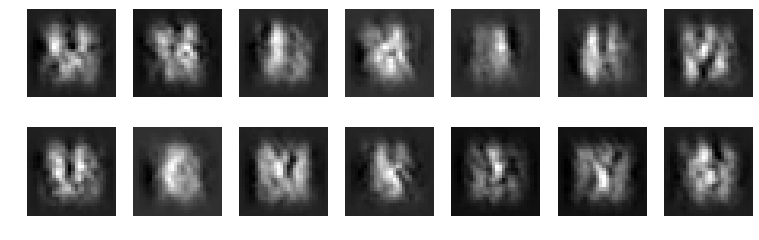

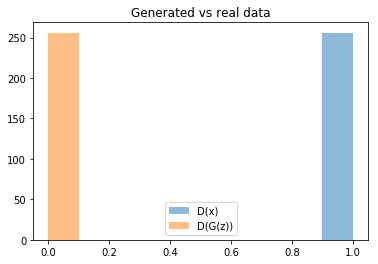

Time for epoch 122 is 7.840336613357067 min
error D: 1.4556842870661058e-05, error G: -7.410899343085475e-06
Time for epoch 123 is 7.8965649120509624 min
error D: 0.007086726371198893, error G: -1.0057157851406373e-05
Time for epoch 124 is 7.95479666441679 min
error D: 2.037606645899359e-05, error G: -1.0215546353720129e-05
Time for epoch 125 is 8.01167306303978 min
error D: 1.5703604731243104e-05, error G: -1.293629247811623e-05
Time for epoch 126 is 8.0680140145123 min
error D: 1.6496152966283262e-05, error G: -1.3915043382439762e-05
Time for epoch 127 is 8.124053377658129 min
error D: 2.2072394131100737e-05, error G: -1.3570546798291616e-05
Time for epoch 128 is 8.180699061602354 min
error D: 1.3886765373172238e-05, error G: -1.2128912203479558e-05
Time for epoch 129 is 8.236645478755236 min
error D: 3.755469515454024e-05, error G: -1.3721847608394455e-05
Time for epoch 130 is 8.292313680052757 min
error D: 2.2937063477002084e-05, error G: -1.4509262655337807e-05
Time for epoch 131 

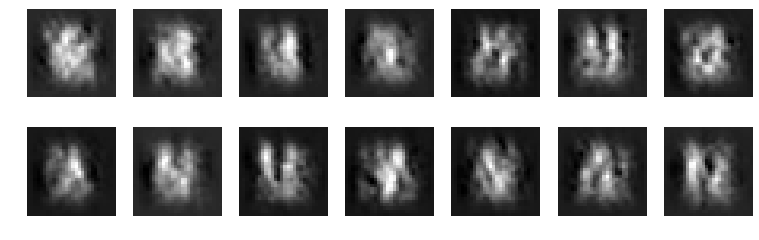

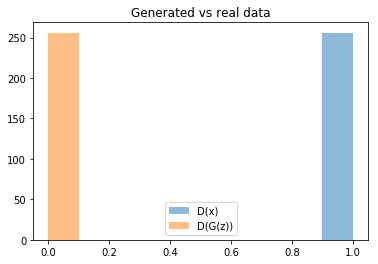

Time for epoch 132 is 8.430493481457233 min
error D: 3.119365283055231e-05, error G: -1.3996163033880293e-05
Time for epoch 133 is 8.487342067062855 min
error D: 2.1142685000086203e-05, error G: -1.6319589121849276e-05
Time for epoch 134 is 8.546719465404749 min
error D: 0.00022440777684096247, error G: -1.4546859347319696e-05
Time for epoch 135 is 8.619088847190142 min
error D: 1.6740845239837654e-05, error G: -1.332928968622582e-05
Time for epoch 136 is 8.67636064440012 min
error D: 0.0002693498390726745, error G: -1.3521668734028935e-05
Time for epoch 137 is 8.731371380388737 min
error D: 4.822684786631726e-05, error G: -1.7798265616875142e-05
Time for epoch 138 is 8.802680261433125 min
error D: 3.265549457864836e-05, error G: -1.4247587387217209e-05
Time for epoch 139 is 8.869913399219513 min
error D: 1.948433418874629e-05, error G: -1.431368673365796e-05
Time for epoch 140 is 8.926476027816534 min
error D: 2.110240893671289e-05, error G: -1.5476811313419603e-05
Time for epoch 141 

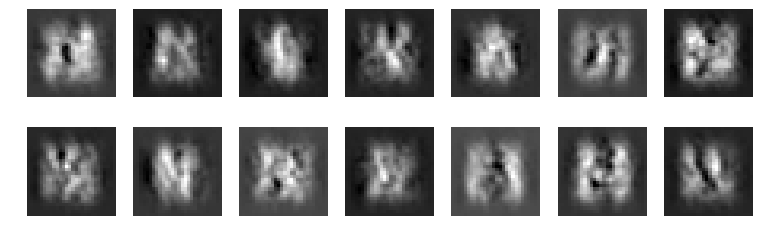

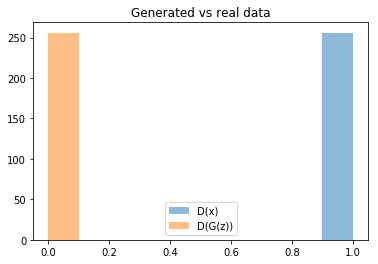

Time for epoch 142 is 9.065145913511515 min
error D: 1.7075893993023783e-05, error G: -1.4530201951856725e-05
Time for epoch 143 is 9.120634563267231 min
error D: 0.00012551600229926407, error G: -1.45861049531959e-05
Time for epoch 144 is 9.176431711763144 min
error D: 1.7350950656691566e-05, error G: -1.4005903722136281e-05
Time for epoch 145 is 9.232553992420435 min
error D: 2.583921559562441e-05, error G: -1.465957575419452e-05
Time for epoch 146 is 9.29256696254015 min
error D: 1.7924750864040107e-05, error G: -1.5308258298318833e-05
Time for epoch 147 is 9.351964380592108 min
error D: 1.774538577592466e-05, error G: -1.4005464436195325e-05
Time for epoch 148 is 9.411551546305418 min
error D: 3.103084600297734e-05, error G: -1.4782524885958992e-05
Time for epoch 149 is 9.467483777552843 min
error D: 1.8262697267346084e-05, error G: -1.4674520571134053e-05
Time for epoch 150 is 9.523711815476418 min
error D: 2.0834133465541527e-05, error G: -1.5333487681346014e-05
Time for epoch 15

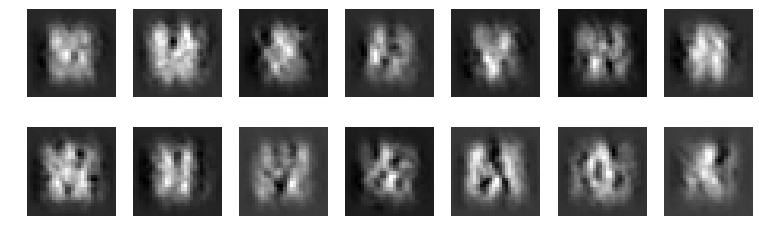

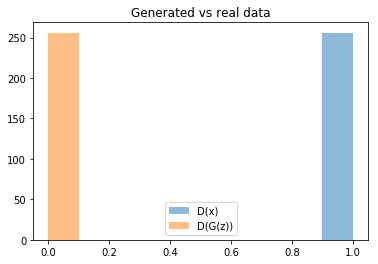

Time for epoch 152 is 9.674595426768064 min
error D: 0.0002400076191406697, error G: -1.4795190509175882e-05
Time for epoch 153 is 9.732709214091301 min
error D: 2.0182753360131755e-05, error G: -1.5386001905426383e-05
Time for epoch 154 is 9.795244932174683 min
error D: 2.8085252779419534e-05, error G: -1.4037994333193637e-05
Time for epoch 155 is 9.852436479181051 min
error D: 1.8905679098679684e-05, error G: -1.74607484950684e-05
Time for epoch 156 is 9.908872947096825 min
error D: 1.933765634021256e-05, error G: -1.3408019185590092e-05
Time for epoch 157 is 9.971830513328314 min
error D: 2.08208330150228e-05, error G: -1.7640119040152058e-05
Time for epoch 158 is 10.042449660599232 min
error D: 2.4230866983998567e-05, error G: -1.5835346857784316e-05
Time for epoch 159 is 10.099716693162918 min
error D: 1.957254426088184e-05, error G: -1.6176243661902845e-05
Time for epoch 160 is 10.155306749045849 min
error D: 1.87770801858278e-05, error G: -1.4444423868553713e-05
Time for epoch 1

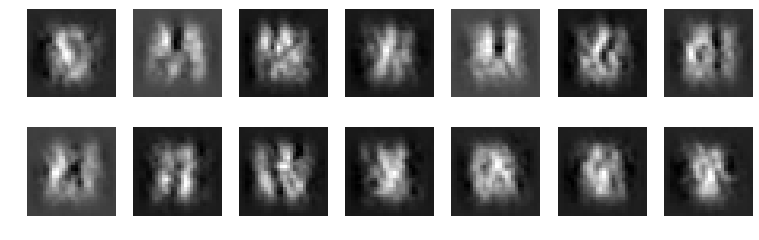

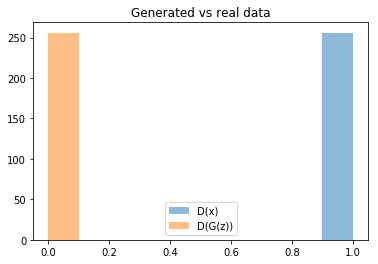

Time for epoch 162 is 10.312637761235237 min
error D: 3.8102283724583685e-05, error G: -1.472302756155841e-05
Time for epoch 163 is 10.375823564827442 min
error D: 3.7378249544417486e-05, error G: -1.5165865079325158e-05
Time for epoch 164 is 10.437780633568764 min
error D: 1.8488106434233487e-05, error G: -1.6213009075727314e-05
Time for epoch 165 is 10.50472454726696 min
error D: 1.9420116586843506e-05, error G: -1.4898930203344207e-05
Time for epoch 166 is 10.586924098432064 min
error D: 1.646173041081056e-05, error G: -1.3927181498729624e-05
Time for epoch 167 is 10.645625464618206 min
error D: 2.1322812244761735e-05, error G: -1.837863601394929e-05
Time for epoch 168 is 10.704027261584997 min
error D: 4.197026282781735e-05, error G: -1.6437028534710407e-05
Time for epoch 169 is 10.762722082436085 min
error D: 2.420193595753517e-05, error G: -1.7420306903659366e-05
Time for epoch 170 is 10.81633223220706 min
error D: 2.1693944290746003e-05, error G: -1.5938678188831545e-05
Time for

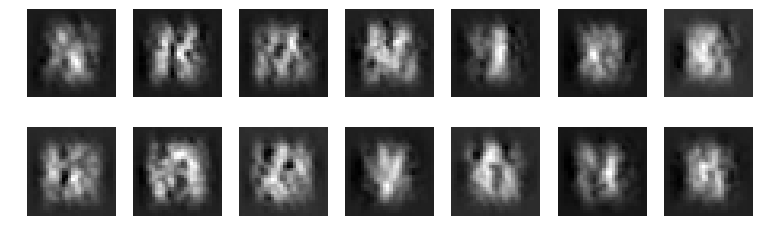

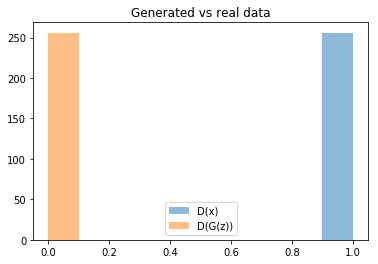

Time for epoch 172 is 10.949832111597061 min
error D: 2.449203748255968e-05, error G: -1.6036525266827084e-05
Time for epoch 173 is 11.00076249614358 min
error D: 1.8581489712232724e-05, error G: -1.5196550521068275e-05
Time for epoch 174 is 11.052258461713791 min
error D: 2.41969246417284e-05, error G: -1.8532631656853482e-05
Time for epoch 175 is 11.105008497834206 min
error D: 1.3674401998287067e-05, error G: -1.2492096175265033e-05
Time for epoch 176 is 88.05186899751425 min
error D: 1.9862678527715616e-05, error G: -1.5893492673058063e-05
Time for epoch 177 is 88.10008676350117 min
error D: 1.6842346667544916e-05, error G: -1.5041679944260977e-05
Time for epoch 178 is 88.14636531472206 min
error D: 1.9222194168833084e-05, error G: -1.546566818433348e-05
Time for epoch 179 is 88.19287038221955 min
error D: 1.744231667544227e-05, error G: -1.2742619219352491e-05
Time for epoch 180 is 88.23931168019772 min
error D: 2.1791633116663434e-05, error G: -1.8053124222205952e-05
Time for epo

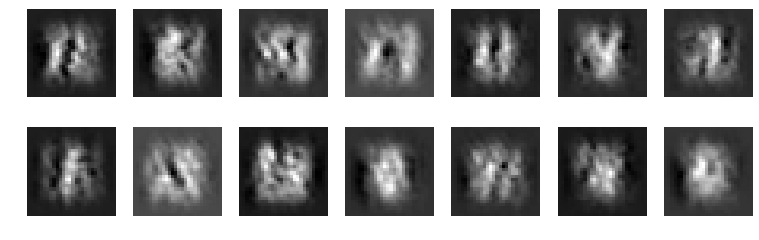

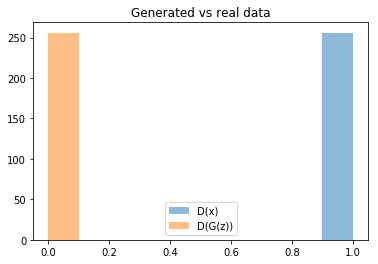

Time for epoch 182 is 88.36131406202912 min
error D: 2.0041248717461713e-05, error G: -1.4759154510102235e-05
Time for epoch 183 is 88.40736598148942 min
error D: 1.7695141650619917e-05, error G: -1.4939461834728718e-05
Time for epoch 184 is 88.45325864851475 min
error D: 2.1633386495523155e-05, error G: -1.4000745068187825e-05
Time for epoch 185 is 88.49901966005564 min
error D: 1.7849355572252534e-05, error G: -1.4060889952816069e-05
Time for epoch 186 is 88.54660025984049 min
error D: 1.5999756215023808e-05, error G: -1.398166386934463e-05
Time for epoch 187 is 88.59298519790173 min
error D: 1.721559965517372e-05, error G: -1.4566998288501054e-05
Time for epoch 188 is 88.63969516381621 min
error D: 1.919777787406929e-05, error G: -1.5228518350340892e-05
Time for epoch 189 is 88.68730089440942 min
error D: 2.9282024115673266e-05, error G: -1.4663377442047931e-05
Time for epoch 190 is 88.73579152673483 min
error D: 2.2203426851774566e-05, error G: -1.3853064956492744e-05
Time for epoc

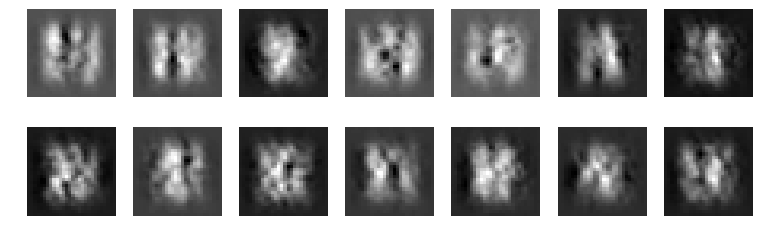

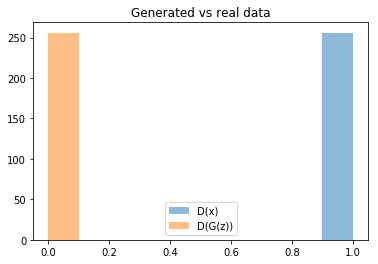

In [ ]:
from IPython import display

EPOCHS = 5000
BSIZE = 256

# время
start = time.time()/60

# вектора для мониторинга сходимости сеток
d_losses = [ ]
g_losses = [ ]

num = 0 # для сохранения картинок 

# запускаем цикл обучения 
for epoch in range(EPOCHS):
    
    # генерируем батч
    X_batch = sample_data_batch(BSIZE)
    X_fake = sample_noise_batch(BSIZE)
    
    # делаем N шагов обучения дискриминатора
    for i in range(5):
        train_discriminator_step(X_batch, X_fake)
        
    # делаем K шагов обучения генератора
    for i in range(1):
        train_generator_step(X_batch, X_fake)

    gen_log = discriminator(generator(X_fake))
    real_log = discriminator(X_batch) 
    
    d_losses.append(discriminator_loss(real_log, gen_log).numpy())
    g_losses.append(generator_loss(gen_log).numpy())
        
    # ну сколько можно ждааать!!! 
    if epoch % 1==0:
        print('Time for epoch {} is {} min'.format(epoch + 1, time.time()/60-start))
        print('error D: {}, error G: {}'.format(d_losses[-1], g_losses[-1]))

    if epoch % 10==0:
        # сохраняем модель и обновляем картинку
        # checkpoint.save(file_prefix = checkpoint_prefix)

        # можно раскоментировать, если хочется, чтобы картинка обновлялась, а не дополнялас
        #display.clear_output(wait=True)
        num += 1
        sample_images(2,7, num)
        sample_probas(X_batch)

Тренируем сетки.

In [ ]:
# сетка тренировалась много итераций
sample_images(4,8)  

In [ ]:
# смотрим сошлись ли потери
plt.plot(d_losses, label='Discriminator')
plt.plot(g_losses, label='Generator')
plt.ylabel('loss')
plt.legend();

# 7. Интерполяция 

Давайте попробуем взять два вектора, сгенерированных из нормального распределения и посмотреть как один из них перетекакет в другой. 

In [ ]:
from scipy.interpolate import interp1d

def show_interp_samples(point1, point2, N_samples_interp):
    N_samples_interp_all = N_samples_interp + 2

    # линия между двумя точками
    line = interp1d([1, N_samples_interp_all], np.vstack([point1, point2]), axis=0)

    fig = plt.figure(figsize=(15,4))
    for i in range(N_samples_interp_all):
        ax = fig.add_subplot(1, 2 + N_samples_interp, i+1)
        ax.grid('off')
        ax.axis('off')
        ax.imshow(generator.predict(line(i + 1).reshape((1, 100)))[0, :, :, 0],cmap='gray')
    plt.show()
    pass

In [ ]:
np.random.seed(seed=42)

# Рандомная точка в пространстве
noise_1 = np.random.normal(0, 1, (1, 100))

# смотрим как она перетекает в симметричкную
show_interp_samples(noise_1, -noise_1, 6)

In [ ]:
noise_2 = np.random.normal(0, 1, (1, 100))
show_interp_samples(noise_1, noise_2, 6)

А что мы вообще сгенерировали?! Давайте посмотрим на точку из выборки наиболее близкую к получившейся генерации.

In [ ]:
id_label_sample = 8
img_smp = generator.predict(sample_noise_batch(1))
plt.imshow(img_smp[0,:,:,0], cmap='gray')

In [ ]:
img_smp.shape, X.shape

In [ ]:
# ищем l1 норму между тем, что сгенерилось и остальным 
L1d = np.sum(np.sum(np.abs(X[:,:,:,0] - img_smp[:,:,:,0]), axis=1), axis=1)
idx_l1_sort = L1d.argsort()
idx_l1_sort.shape

In [ ]:
idx_l1_sort[:5]

In [ ]:
N_closest = 8

fig = plt.figure(figsize=(15,4))
for i in range(N_closest):
    ax = fig.add_subplot(1, N_closest, i+1)
    ax.grid('off')
    ax.axis('off')
    ax.imshow(X[idx_l1_sort[i], :, :, 0], cmap='gray')
plt.show()

Сохраняю гифку из картинок. 

In [ ]:
import os
import glob
import imageio

def create_animated_gif(files, animated_gif_name, pause=0):
    if pause != 0:
        # Load the gifs up several times in the array, to slow down the animation
        frames = []
        for file in files:
            count = 0
            while count < pause:
                frames.append(file)
                count+=1
        print("Total number of frames in the animation:", len(frames))
        files = frames
    images = [imageio.imread(file) for file in files]
    imageio.mimsave(animated_gif_name, images, duration = 0.005)

In [ ]:
pause = 1
animated_gif_name = 'animation_GAN.gif'

In [ ]:
image_path = 'images_gan/*.png'
files = glob.glob(image_path)
files = sorted(files, key = lambda w: int(w.split('_')[-1].split('.')[0]))
create_animated_gif(files, animated_gif_name, pause)

# Задание : 

* Превратить нашу GAN в Conditional GAN 

![](https://camo.githubusercontent.com/63a263678253a1eedd74432ad85751da2407a3d8/687474703a2f2f6775696d70657261726e61752e636f6d2f66696c65732f626c6f672f46616e7461737469632d47414e732d616e642d77686572652d746f2d66696e642d7468656d2f6347414e5f6f766572766965772e6a7067)

На этом всё :) 

![](https://miro.medium.com/max/896/1*3VOLkgm-QY05gEpGDkBzTA.gif)